In [64]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


In [65]:
nltk.download('stopwords')

import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

=3


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 1. 데이터 수집하기

In [66]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [67]:
#랜덤한 10개 샘플 출력
data.sample(10)

,headlines,text
51783,Fastrack brings Faketionary for the world to '...,After launching the new Shut The Fake Up campa...
65295,70 telescopes confirmed light tied with gravit...,Over 70 space and ground-based observatories h...
19878,Warren Buffett's Berkshire Hathaway confirms i...,World's third richest person Warren Buffett-le...
38802,Cannot believe what one video did for us: Suni...,Referring to the video he shared urging the fa...
43806,"Dinosaur-bird Archaeopteryx could fly, but in ...",Dinosaur-bird Archaeopteryx was capable of fly...
12267,Korea shaving firm Dorco buys 10% stake in Ind...,Korean shaving company Dorco has acquired a 10...
18557,250 Twitter handles spread fake news on Bhima-...,Maharashtra Police on Wednesday alleged that a...
11529,India was unfortunate that Sardar Patel wasn't...,Madhya Pradesh CM Shivraj Singh Chouhan on Wed...
1499,Court refuses chargesheet by Delhi Police agai...,A Delhi court on Saturday pulled up Delhi Poli...
46470,A case of faulty camera angles: Papon on kissi...,"Singer Papon, while addressing the controversy..."


- 이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

- 추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

## Step 2. 데이터 전처리하기 (추상적 요약)
- 실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

### (1) 데이터 정리하기

- 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [68]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

print(data.isnull().sum())
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
전체 샘플수 : 98360
headlines    0
text         0
dtype: int64
전체 샘플수 : 98360


- 텍스트 정규화와 불용어 제거

In [69]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [70]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

In [71]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [72]:
# 전체 headlines 데이터에 대한 전처리 
clean_headlines = []

for t in data['headlines']:
    clean_headlines.append(preprocess_sentence(t, False))

# 전처리 후 출력
print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [73]:
# 전체 text 데이터에 대한 전처리 
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s, True))

print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [74]:
data['headlines'] = clean_headlines
data['text'] = clean_text

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

data.isnull().sum()
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

=3
전체 샘플수 : 98360


### (2) 훈련데이터와 테스트데이터 나누기

- 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 16
텍스트의 평균 길이 : 9.299532330215534
요약의 최소 길이 : 1
요약의 최대 길이 : 60
요약의 평균 길이 : 35.09968483123221


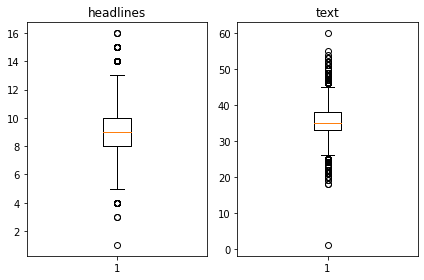

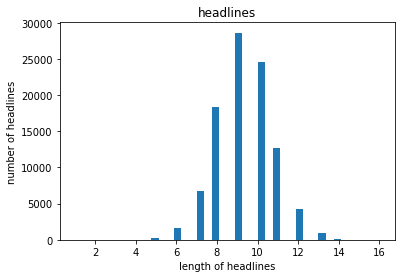

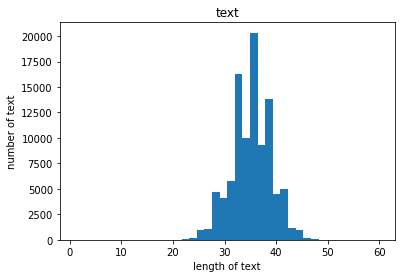

In [75]:
# 길이 분포 출력
import matplotlib.pyplot as plt

headlines_len = [len(s.split()) for s in data['headlines']]
text_len = [len(s.split()) for s in data['text']]

print('텍스트의 최소 길이 : {}'.format(np.min(headlines_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(headlines_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('요약의 최소 길이 : {}'.format(np.min(text_len)))
print('요약의 최대 길이 : {}'.format(np.max(text_len)))
print('요약의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of headlines')
plt.ylabel('number of headlines')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of text')
plt.ylabel('number of text')
plt.show()

In [76]:
headlines_max_len = 10
text_max_len = 40

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(headlines_max_len,  data['headlines'])
below_threshold_len(text_max_len, data['text'])

data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687
전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플수 : 74102


- 시작 토큰과 종료 토큰 추가하기

In [77]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [78]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [79]:
# 훈련 데이터와 테스트 데이터를 분리
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

[54540  3330 12551 ... 16538  3965 38827]
=3
테스트 데이터의 수 : 14820


In [80]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


### (3) 정수 인코딩

- 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [81]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [82]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61606
등장 빈도가 6번 이하인 희귀 단어의 수: 42323
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19283
단어 집합에서 희귀 단어의 비율: 68.6994773236373
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.193400795853523


In [83]:
src_vocab = int(total_cnt - rare_cnt)
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 int(total_cnt - rare_cnt)으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

=3
[[2, 15, 61, 1246, 27, 2144, 140, 111, 262, 83, 47, 477, 5258, 5, 4340, 192, 46, 2058, 262, 107, 263, 112, 442, 7928, 2579, 1247, 4190, 5594, 1055, 177, 11, 2937], [58, 16, 16, 1147, 971, 449, 8274, 3257, 11752, 2603, 2956, 10044, 111, 534, 424, 14, 889, 16896, 16897, 1, 26, 6, 677, 507, 6236, 689, 79, 6442, 2378, 3257, 768, 74, 3053, 878, 3], [3979, 99, 16898, 3809, 751, 200, 147, 55, 134, 9, 309, 915, 986, 5071, 19, 95, 406, 109, 1755, 6628, 19, 8, 670, 16, 2181, 147, 200, 272, 3258, 19, 1147, 58, 16]]


In [84]:
# headlines 데이터도 마찬가지로 진행

In [85]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27304
등장 빈도가 5번 이하인 희귀 단어의 수: 18254
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9050
단어 집합에서 희귀 단어의 비율: 66.85467330794023
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.964532797720211


In [86]:
tar_vocab = int((total_cnt - rare_cnt))
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 35, 746, 1993, 13, 23, 152], [1, 4129, 3216, 3, 928, 41, 41, 329, 61], [1, 1892, 40, 257, 220, 284, 17, 756, 4, 209, 503], [1, 62, 6, 1164, 53, 4669, 2296, 7, 5719, 826], [1, 4469, 940, 198, 361, 306, 827, 5720, 6]]
target
decoder  [[35, 746, 1993, 13, 23, 152, 2], [4129, 3216, 3, 928, 41, 41, 329, 61, 2], [1892, 40, 257, 220, 284, 17, 756, 4, 209, 503, 2], [62, 6, 1164, 53, 4669, 2296, 7, 5719, 826, 2], [4469, 940, 198, 361, 306, 827, 5720, 6, 2]]


In [87]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


- 패딩하기

In [88]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
- 일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

### 모델 설계하기

In [89]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Attention, AdditiveAttention

# 하이퍼파라미터 설정
embedding_dim = 128
hidden_size = 256

# Encoder 입력
# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# Encoder LSTM 2층으로 구성함
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h2, state_c2 = encoder_lstm2(encoder_output1)


# Decoder 입력
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h2, state_c2])

from tensorflow.keras.layers import AdditiveAttention

# 어텐션 메커니즘 (Bahdanau)

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 최종 모델
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 128)      2468224     input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 40, 256), (N 394240      embedding_2[0][0]                
____________________________________________________________________________________________

### 모델훈련하기

Epoch 1/50
232/232 [==============================] - 20s 70ms/step - loss: 6.3113 - val_loss: 5.8730
Epoch 2/50
232/232 [==============================] - 16s 67ms/step - loss: 5.7801 - val_loss: 5.5669
Epoch 3/50
232/232 [==============================] - 16s 69ms/step - loss: 5.4596 - val_loss: 5.3134
Epoch 4/50
232/232 [==============================] - 16s 70ms/step - loss: 5.1910 - val_loss: 5.0901
Epoch 5/50
232/232 [==============================] - 16s 70ms/step - loss: 4.9369 - val_loss: 4.8983
Epoch 6/50
232/232 [==============================] - 16s 71ms/step - loss: 4.7224 - val_loss: 4.7903
Epoch 7/50
232/232 [==============================] - 16s 71ms/step - loss: 4.5462 - val_loss: 4.6690
Epoch 8/50
232/232 [==============================] - 16s 70ms/step - loss: 4.3865 - val_loss: 4.5718
Epoch 9/50
232/232 [==============================] - 16s 70ms/step - loss: 4.2440 - val_loss: 4.5145
Epoch 10/50
232/232 [==============================] - 16s 70ms/step - loss: 4.113

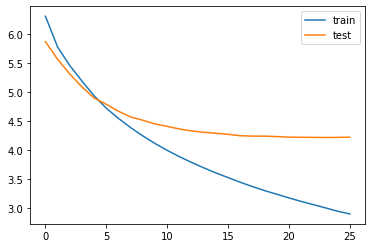

In [90]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

In [91]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h2, state_c2])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence


### 모델 테스트하기

In [94]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if i != 0 and tar_index_to_word[i] != 'sostoken' and tar_index_to_word[i] != 'eostoken':
            temp += tar_index_to_word[i] + ' '
    return temp.strip() # strip 마지막 공백을 지우기위해서


print('=3')



=3


## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
- 원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [ ]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tar_tokenizer.word_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    loop_count = 0  # safety

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tar_index_to_word.get(sampled_token_index, '')

        if (sampled_word == 'eostoken' or
            len(decoded_sentence.split()) >= max_summary_len):
            stop_condition = True

        else:
            decoded_sentence += sampled_word + ' '

            target_seq[0, 0] = sampled_token_index
            states_value = [h, c]

        loop_count += 1
        if loop_count > 100:
            print("⚠️ 경고: 무한 루프 가능성, 강제 종료")
            break

    return decoded_sentence.strip()


def compare_with_headlines(n=5):
    for i in range(n):
        print("="*100)
        print(f" 원문 {i+1}")
        print(sequence_to_text(encoder_input_test[i], src_index_to_word))
        
        print("\n [모델 요약]")
        print(decode_sequence(encoder_input_test[i].reshape(1, -1)))

        print("\n [실제 Headline 요약]")
        print(headlines[i])  # 실제 headline (원시 문자열 그대로)
        print("="*100 + "\n")

        
compare_with_headlines(1)



## Step 5. Summa을 이용해서 추출적 요약해보기
- text열만 사용하기
- 추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

- Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [ ]:
from summa.summarizer import summarize
import os
home = os.getenv('HOME')
path = os.path.join(home, 'news_summary_more.csv')
with open(path, encoding = 'UTF-8') as f:
    text = f.read()
print(text[:1500])

### summarize 사용하기

In [ ]:
print('Summary:')
print(summarize(text, ratio=0.05, split=True))
print('Summary:')
print(summarize(text, words=50))

# 회고

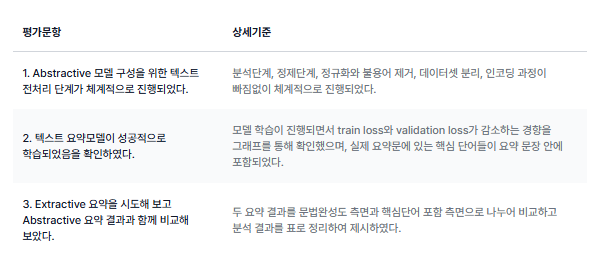

- [x] 데이터 전처리를 3단계로 모두 수행함
- [x] 텍스트 요약 모델의 성공 여부를 확인함
- [x] 추상적 요약과 추출적 요약 결과를 표로 정리함 (아래)


In [ ]:
import pandas as pd

results = []

for i in range(n):
    original_text = sequence_to_text(encoder_input_test[i], src_index_to_word)
    abstractive = decode_sequence(encoder_input_test[i].reshape(1, -1))
    extractive = summarize(original_text, ratio=0.3)
    headline = headlines[i]

    results.append({
        "원문": original_text,
        "추출 요약": extractive,
        "추상 요약": abstractive,
        "실제 Headline": headline
    })

df = pd.DataFrame(results)
display(df.head())
